Download your Google Location History from: https://takeout.google.com/settings/takeout

Put the `Location History.json` file in the same directory as this.

Run all cells in this notebook.

In [1]:
%matplotlib inline

In [2]:
import datetime
import json

import geopandas as gp
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

plt.style.use('fivethirtyeight')

In [3]:
## Parameters ##
#==============#

# Centroids of home and work locations in lat/lonE7
home = (-739570500, 406310500)
work = (-740023790, 407157170)

# Size of buffer around home/work centroids
buffer = 20000


# Optional parameters to further improve the results.  
# ===================================================
# Days that you work 0 = Monday, 6 = Sunday
workdays = [0, 1, 2, 3, 4]

# Time period commuting between this pair of home/work locations
timeframe = ['2016-09-12', '2018-01-01']

# Possible commute times in minutes for your commute.  
# For instance, if you know the commute should never be less than 20 minutes
# or greater than 3 hours, then use range [20, 180]
possible_commute_times = [20, 180]

# Time range when you depart for work in hours.
# For example, leaving for work between 7:00 and 9:00
departure_timeframe = [datetime.time(7), datetime.time(9)]

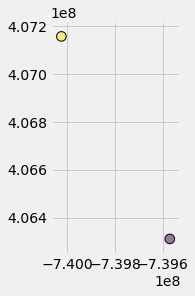

In [4]:
locations = gp.GeoDataFrame({
    'location': ['home', 'work'], 
    'geometry': [Point(home).buffer(buffer), Point(work).buffer(buffer)]
})

locations.crs = {'init' :'epsg:4326'}
locations.plot()

In [5]:
with open('Location History.json') as data_file:    
    data = json.load(data_file)
    
df = pd.DataFrame.from_records(data['locations'])
df['timestampMs'] = df['timestampMs'].astype('int64')
df['timestamp'] = pd.to_datetime(df['timestampMs'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df['geometry'] = df.apply(lambda r: Point(r['longitudeE7'], r['latitudeE7']), axis=1)

df['date'] = df['timestamp'].dt.date
df['weekday'] = df['timestamp'].dt.weekday

gdf = gp.GeoDataFrame(df[
    (df['weekday'].isin(workdays)) & 
    (df['timestamp'].between(pd.to_datetime(timeframe[0]), pd.to_datetime(timeframe[1])))
])
gdf.crs = {'init' :'epsg:4326'}

In [6]:
joined = gp.sjoin(locations, gdf, op='contains').reset_index().sort_values('timestamp')

joined['location_i'] = 0
joined.loc[joined['location'] == 'work', 'location_i'] = 1
joined['diff'] = joined['location_i'].diff()
joined['timediff'] = joined['timestamp'].diff()


joined

,index,geometry,location,index_right,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,timestamp,date,weekday,location_i,diff,timediff
116194,0,"POLYGON ((-739550500 406310500, -739550596.305...",home,514090,9,NaN,-7.0,NaN,406309679,-739583428,1473652811000,0.0,NaN,2016-09-12 00:00:11-04:00,2016-09-12,0,0,NaN,NaT
116193,0,"POLYGON ((-739550500 406310500, -739550596.305...",home,514089,4,NaN,-7.0,NaN,406309678,-739583426,1473652826000,0.0,NaN,2016-09-12 00:00:26-04:00,2016-09-12,0,0,0.0,00:00:15
116192,0,"POLYGON ((-739550500 406310500, -739550596.305...",home,514088,4,NaN,-7.0,NaN,406309677,-739583424,1473652844000,0.0,NaN,2016-09-12 00:00:44-04:00,2016-09-12,0,0,0.0,00:00:18
116191,0,"POLYGON ((-739550500 406310500, -739550596.305...",home,514087,4,NaN,-7.0,NaN,406309676,-739583424,1473652859000,0.0,NaN,2016-09-12 00:00:59-04:00,2016-09-12,0,0,0.0,00:00:15
116190,0,"POLYGON ((-739550500 406310500, -739550596.305...",home,514086,8,NaN,-7.0,NaN,406309674,-739583423,1473652874000,0.0,NaN,2016-09-12 00:01:14-04:00,2016-09-12,0,0,0.0,00:00:15
116189,0,"POLYGON ((-739550500 406310500, -739550596.305...",home,514085,6,NaN,-7.0,NaN,406309674,-739583422,1473652892000,0.0,NaN,2016-09-12 00:01:32-04:00,2016-09-12,0,0,0.0,00:00:18
116188,0,"POLYGON ((-739550500 406310500, -739550596.305...",home,514084,3,NaN,-7.0,NaN,406309673,-739583422,1473652907000,0.0,NaN,2016-09-12 00:01:47-04:00,2016-09-12,0,0,0.0,00:00:15
116187,0,"POLYGON ((-739550500 406310500, -739550596.305...",home,514083,4,NaN,-7.0,NaN,406309672,-739583422,1473652925000,0.0,NaN,2016-09-12 00:02:05-04:00,2016-09-12,0,0,0.0,00:00:18
116186,0,"POLYGON ((-739550500 406310500, -739550596.305...",home,514082,6,NaN,-7.0,NaN,406309671,-739583422,1473652940000,0.0,NaN,2016-09-12 00:02:20-04:00,2016-09-12,0,0,0.0,00:00:15
83452,0,"POLYGON ((-739550500 406310500, -739550596.305...",home,514081,4,NaN,-13.0,NaN,406309672,-739583153,1473652956000,0.0,NaN,2016-09-12 00:02:36-04:00,2016-09-12,0,0,0.0,00:00:16


In [7]:
commute_times = joined[
    (joined['diff'] == 1)
]

commute_times['departure_time'] = commute_times['timestamp'] - commute_times['timediff']

commute_times = commute_times[
    commute_times['timediff'].between(
        pd.Timedelta(minutes=possible_commute_times[0]), 
        pd.Timedelta(minutes=possible_commute_times[1])
    ) &
    commute_times['departure_time'].dt.time.between(
        departure_timeframe[0], departure_timeframe[1]
    )
]

commute_times

c:\Users\jneiman\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,index,geometry,location,index_right,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,timestamp,date,weekday,location_i,diff,timediff,departure_time
228267,1,"POLYGON ((-740003790 407157170, -740003886.305...",work,509079,11,"[{'activity': [{'type': 'ON_FOOT', 'confidence...",-26.0,204.0,407173405,-740016298,1473769644000,0.0,NaN,2016-09-13 08:27:24-04:00,2016-09-13,1,1,1.0,00:40:07,2016-09-13 07:47:17-04:00
217545,1,"POLYGON ((-740003790 407157170, -740003886.305...",work,505526,50,"[{'activity': [{'type': 'ON_FOOT', 'confidence...",NaN,NaN,407174551,-740015050,1473856037198,NaN,NaN,2016-09-14 08:27:17.198000-04:00,2016-09-14,2,1,1.0,00:39:09.623000,2016-09-14 07:48:07.575000-04:00
273454,1,"POLYGON ((-740003790 407157170, -740003886.305...",work,502877,52,"[{'activity': [{'type': 'ON_FOOT', 'confidence...",NaN,NaN,407158840,-740022152,1473942738245,NaN,NaN,2016-09-15 08:32:18.245000-04:00,2016-09-15,3,1,1.0,00:40:52.059000,2016-09-15 07:51:26.186000-04:00
228265,1,"POLYGON ((-740003790 407157170, -740003886.305...",work,499499,20,"[{'activity': [{'type': 'ON_FOOT', 'confidence...",NaN,NaN,407173136,-740015969,1474028739217,NaN,NaN,2016-09-16 08:25:39.217000-04:00,2016-09-16,4,1,1.0,00:35:06.655000,2016-09-16 07:50:32.562000-04:00
228611,1,"POLYGON ((-740003790 407157170, -740003886.305...",work,494332,21,NaN,NaN,NaN,407171209,-740018723,1474288294013,NaN,NaN,2016-09-19 08:31:34.013000-04:00,2016-09-19,0,1,1.0,00:38:43.689000,2016-09-19 07:52:50.324000-04:00
227690,1,"POLYGON ((-740003790 407157170, -740003886.305...",work,492427,24,"[{'activity': [{'type': 'ON_FOOT', 'confidence...",NaN,NaN,407170307,-740017805,1474376172637,NaN,NaN,2016-09-20 08:56:12.637000-04:00,2016-09-20,1,1,1.0,00:36:17.637000,2016-09-20 08:19:55-04:00
217720,1,"POLYGON ((-740003790 407157170, -740003886.305...",work,488778,12,"[{'activity': [{'type': 'ON_FOOT', 'confidence...",-39.0,240.0,407173547,-740015433,1474462591000,1.0,NaN,2016-09-21 08:56:31-04:00,2016-09-21,2,1,1.0,00:38:23,2016-09-21 08:18:08-04:00
229845,1,"POLYGON ((-740003790 407157170, -740003886.305...",work,485323,21,NaN,NaN,NaN,407169022,-740019641,1474549197765,NaN,NaN,2016-09-22 08:59:57.765000-04:00,2016-09-22,3,1,1.0,00:42:40.765000,2016-09-22 08:17:17-04:00
228264,1,"POLYGON ((-740003790 407157170, -740003886.305...",work,483050,13,NaN,20.0,158.0,407173642,-740016852,1474635771000,1.0,NaN,2016-09-23 09:02:51-04:00,2016-09-23,4,1,1.0,00:39:32,2016-09-23 08:23:19-04:00
217297,1,"POLYGON ((-740003790 407157170, -740003886.305...",work,472903,15,NaN,-35.0,NaN,407174991,-740015179,1474894521000,0.0,NaN,2016-09-26 08:55:21-04:00,2016-09-26,0,1,1.0,00:34:52.071000,2016-09-26 08:20:28.929000-04:00


In [8]:
commute_times.describe()[['timediff']]

,timediff
count,190
mean,0 days 00:40:41.563652
std,0 days 00:07:14.645731
min,0 days 00:21:26.971000
25%,0 days 00:36:48.543000
50%,0 days 00:39:16.256500
75%,0 days 00:42:31.046750
max,0 days 01:23:16.493000


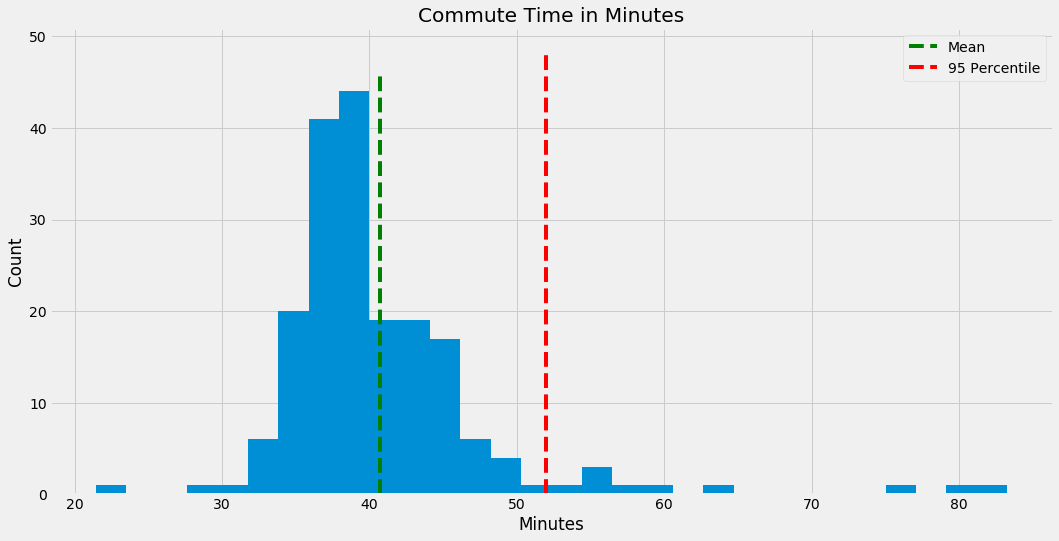

In [9]:
figure, ax = plt.subplots(figsize=(16, 8))

(commute_times['timediff'].dt.total_seconds() / 60).hist(ax=ax, bins=30)

ax.plot(
    [commute_times['timediff'].mean().total_seconds()/60 for i in range(2)],
    ax.get_ylim(), 'g--', label='Mean'
)

ax.plot(
    [commute_times['timediff'].quantile(.95).total_seconds()/60 for i in range(2)],
    ax.get_ylim(), 'r--', label='95 Percentile'
)

ax.set_title('Commute Time in Minutes')
ax.set_xlabel('Minutes')
ax.set_ylabel('Count')
ax.legend()

#commute_times